In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import time
import numpy as np

from imp import reload

import qcodes as qc

qc.halt_bg()
# qc.set_mp_method('spawn')  # force Windows behavior on mac

# this makes a widget in the corner of the window to show and control
# subprocesses and any output they would print to the terminal
qc.show_subprocess_widget()

C:\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>

No loop running


In [2]:
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver; reload(ATSdriver)
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

In [3]:
contr1 = ats_contr.Test_AcquisitionController()

In [19]:
contr2 = ats_contr.HD_Controller(10e6)

In [5]:
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1', server_name=None)

In [6]:
ats_inst.config(clock_source='INTERNAL_CLOCK',
                sample_rate=500000000,
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.4, 0.4],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=150,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='DC',
                external_trigger_range='ETR_5V',
                trigger_delay=0,
                timeout_ticks=0)

In [30]:
resA, resB = ats_inst.acquire(mode='NPT',
                             samples_per_record=1024,
                             records_per_buffer=10,
                             buffers_per_acquisition=1,
                             channel_selection='AB',
                             transfer_offset=0,
                             external_startcapture='DISABLED',
                             enable_record_headers='DISABLED',
                             alloc_buffers='ENABLED',
                             fifo_only_streaming='DISABLED',
                             interleave_samples='DISABLED',
                             get_processed_data='ENABLED',
                             allocated_buffers=2,
                             buffer_timeout=10,
                             acquisition_controller=contr1)

bytes per sample 2
samples_per_record is 1024
bytes per record is 2048
samples_per_buffer is 10240
bytes_per_buffer  is 40960
records_per_buffer is 10
buffers cleared
made buffer list length 2
completed AlazarPostAsyncBuffer
Capturing 1 buffers.
buffers cleared


In [31]:
resA[1]-resB[1]+180

4340.0

In [32]:
resB

array([ 57568.,  58080.,  58624., ...,  73280.,  73248.,  73184.])

In [33]:
ats_inst.get_idn()['bits_per_sample']

12

In [34]:
ats_inst.get_sample_speed()

500000000

<IPython.core.display.Javascript object>


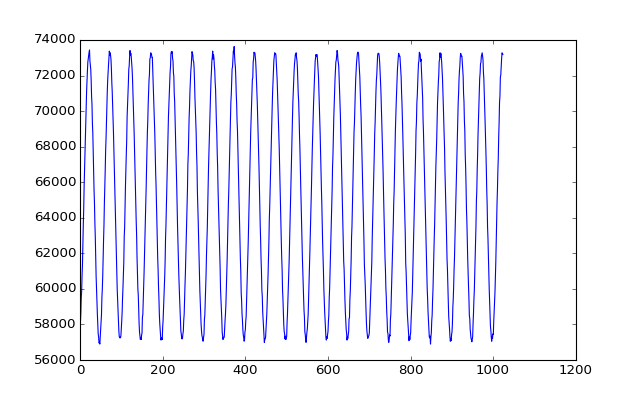

In [35]:
qc.MatPlot(resB)

<IPython.core.display.Javascript object>


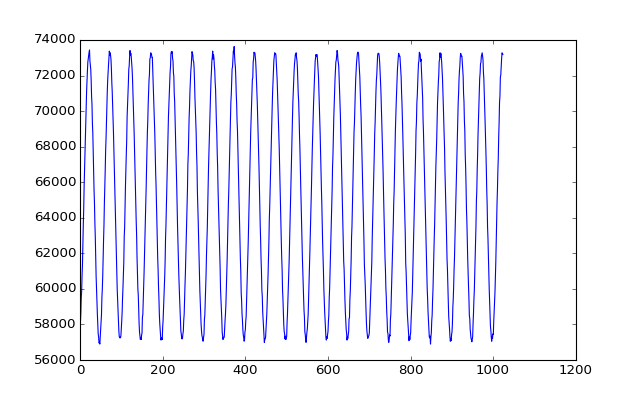

In [36]:
qc.MatPlot(resB)

In [6]:
ats_inst.get_idn()

TypeError: __init__() got an unexpected keyword argument 'system_id'

In [ ]:
import qcodes.instrument_drivers.AlazarTech.ATS